Sentinel

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

In [10]:
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-07-16T15:00:00/2021-09-07T16:00:00"

In [11]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

items = list(search.get_items())

signed_items = [planetary_computer.sign(item).to_dict() for item in items]

resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [12]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

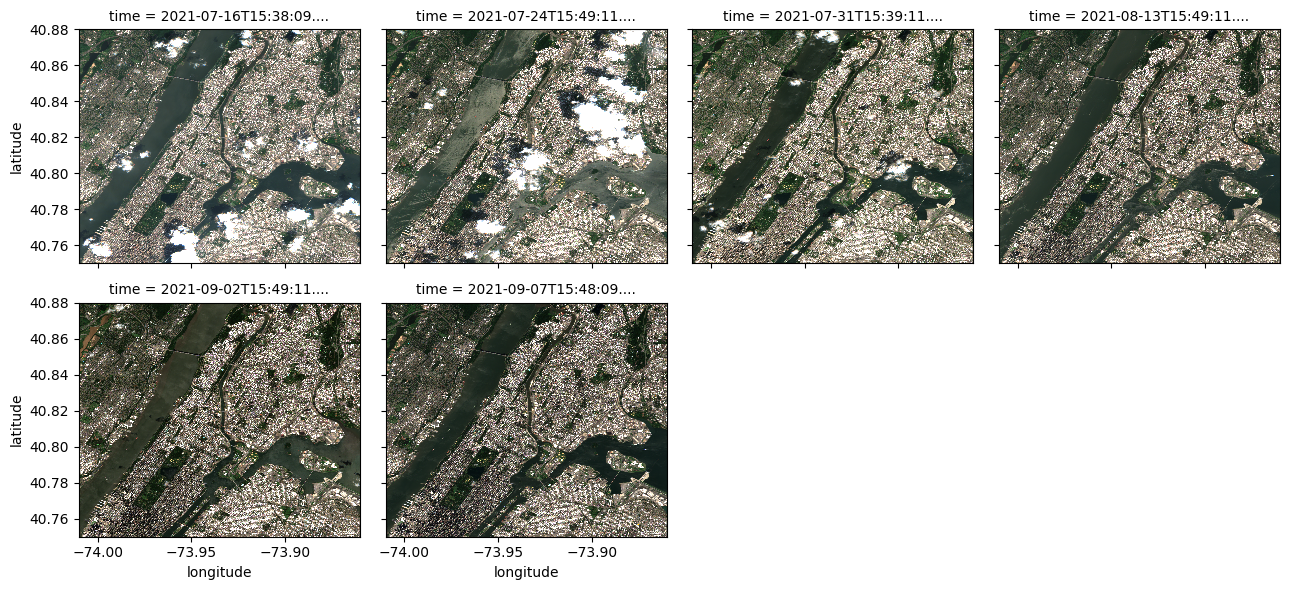

In [13]:
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

In [14]:
filename = "S2.tiff"
data_slice = data.isel(time=5)
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=11,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B01,1)
    dst.write(data_slice.B02,2)
    dst.write(data_slice.B03,3)
    dst.write(data_slice.B04,4)
    dst.write(data_slice.B05,5)
    dst.write(data_slice.B06,6) 
    dst.write(data_slice.B07,7)
    dst.write(data_slice.B08,8)
    dst.write(data_slice.B8A,9)
    dst.write(data_slice.B11,10)
    dst.write(data_slice.B12,11)
    dst.close()

In [ ]:
median = data.median(dim="time").compute()

In [21]:
import rasterio
import xarray as xr

# Assuming `data` is your xarray Dataset with dimensions (time, latitude, longitude)
# Compute the median along the time dimension
median_data = data.median(dim="time", keep_attrs=True)

# Extract dimensions
height = median_data.dims["latitude"]
width = median_data.dims["longitude"]

# Define the geotransform
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)

# Set CRS and transform for the median data
median_data.rio.write_crs("epsg:4326", inplace=True)
median_data.rio.write_transform(transform=gt, inplace=True)

# Define the output filename for the median GeoTIFF
median_filename = "S2_median.tiff"

# Save the median values to a new GeoTIFF file
with rasterio.open(median_filename, 'w', driver='GTiff', width=width, height=height,
                   crs='epsg:4326', transform=gt, count=11, compress='lzw', dtype='float64') as dst:
    dst.write(median_data.B01.values, 1)  # Band 1
    dst.write(median_data.B02.values, 2)  # Band 2
    dst.write(median_data.B03.values, 3)  # Band 3
    dst.write(median_data.B04.values, 4)  # Band 4
    dst.write(median_data.B05.values, 5)  # Band 5
    dst.write(median_data.B06.values, 6)  # Band 6
    dst.write(median_data.B07.values, 7)  # Band 7
    dst.write(median_data.B08.values, 8)  # Band 8
    dst.write(median_data.B8A.values, 9)  # Band 8A
    dst.write(median_data.B11.values, 10) # Band 11
    dst.write(median_data.B12.values, 11) # Band 12
    dst.close()

Landsat

In [25]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

In [26]:
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

time_window = "2021-06-01/2021-09-01"

In [27]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

items = list(search.get_items())

In [28]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

resolution = 30  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [29]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [30]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [31]:
data1 = data1.persist()
data2 = data2.persist()

In [32]:
scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1
data1

scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius
data2

<xarray.Dataset> Size: 17MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) float64 17MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

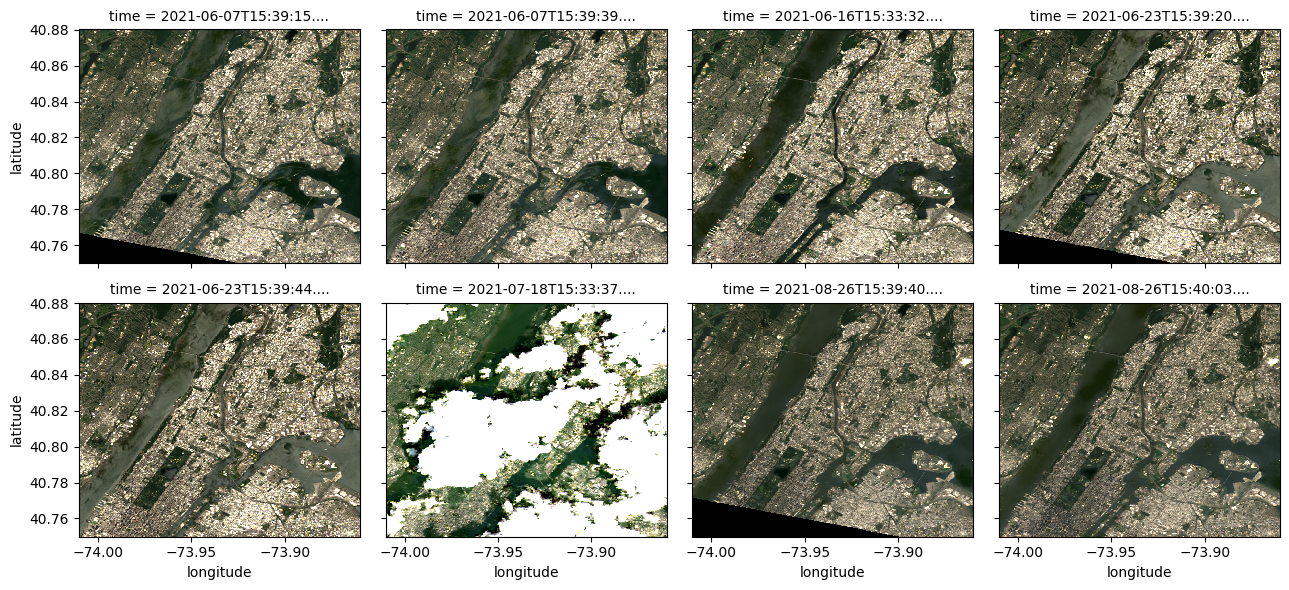

In [33]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

In [34]:
scene = 4
data3 = data2.isel(time=scene)
filename = "L2.tiff"
height = data3.dims["latitude"]
width = data3.dims["longitude"]
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(data3.lwir11,1)
    dst.close()

In [35]:
import rasterio
import xarray as xr

# Assuming `data1` and `data2` are your xarray Datasets
# Combine the bands from both datasets
combined_data = xr.merge([data1, data2])

# Compute the median along the time dimension (if needed)
median_data = combined_data.median(dim="time", keep_attrs=True)

# Extract dimensions
height = median_data.dims["latitude"]  # Assuming y is latitude
width = median_data.dims["longitude"]   # Assuming x is longitude

# Define the geotransform
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)

# Set CRS and transform for the median data
median_data.rio.write_crs("epsg:4326", inplace=True)
median_data.rio.write_transform(transform=gt, inplace=True)

# Define the output filename for the combined GeoTIFF
output_filename = "combined_median.tiff"

# List of bands to save
bands_to_save = ["red", "green", "blue", "nir08", "lwir11"]

# Save the median values to a new GeoTIFF file
with rasterio.open(output_filename, 'w', driver='GTiff', width=width, height=height,
                   crs='epsg:4326', transform=gt, count=len(bands_to_save), compress='lzw', dtype='float64') as dst:
    for i, band in enumerate(bands_to_save, start=1):
        dst.write(median_data[band].values, i)  # Write each band to the GeoTIFF

In [36]:
import rasterio

# Open the GeoTIFF file
with rasterio.open("combined_median.tiff") as src:
    # Print metadata
    print("Metadata:")
    print(src.meta)  # Includes CRS, transform, dimensions, data type, etc.

    # Print the number of bands
    print(f"Number of bands: {src.count}")

    # Print the CRS (Coordinate Reference System)
    print(f"CRS: {src.crs}")

    # Print the spatial transform (affine transformation matrix)
    print(f"Transform: {src.transform}")

    # Print the dimensions (width, height)
    print(f"Width: {src.width}, Height: {src.height}")

    # Print the data type of the bands
    print(f"Data type: {src.dtypes}")

    # Read and print the first band (for example)
    band1 = src.read(1)
    print("First band data:")
    print(band1)

Metadata:
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 558, 'height': 484, 'count': 5, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026881720430108546, 0.0, -74.01,
       0.0, -0.0002685950413223193, 40.88)}
Number of bands: 5
CRS: EPSG:4326
Transform: | 0.00, 0.00,-74.01|
| 0.00,-0.00, 40.88|
| 0.00, 0.00, 1.00|
Width: 558, Height: 484
Data type: ('float64', 'float64', 'float64', 'float64', 'float64')
First band data:
[[0.07099875 0.1028575  0.1634675  ... 0.13930875 0.09412625 0.09987375]
 [0.0836625  0.07611375 0.09770125 ... 0.2145075  0.14508375 0.10399875]
 [0.0905375  0.080885   0.0748625  ... 0.1481225  0.17181375 0.1205675 ]
 ...
 [0.051845   0.0575375  0.

Project

In [38]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



In [39]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


In [45]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
S_tiff_path = "S2.tiff"

def map_satellite_data(S_tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B05_values = []
    B06_values = []
    B07_values = []
    B08_values = []
    B8A_values = []
    B11_values = []
    B12_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

        B02_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B02_values.append(B02_value)

        B03_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B03_values.append(B03_value)
    
        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)

        B05_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B05_values.append(B05_value)
        
        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)

        B07_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B07_values.append(B07_value)
    
        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        B8A_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B8A_values.append(B8A_value)

        B11_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B11_values.append(B11_value)

        B12_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B12_values.append(B12_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B01_values
    df['B03'] = B01_values
    df['B04'] = B04_values
    df['B05'] = B01_values
    df['B06'] = B06_values
    df['B07'] = B01_values
    df['B08'] = B01_values
    df['B8A'] = B08_values
    df['B11'] = B01_values
    df['B12'] = B01_values
    
    return df


In [44]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
L_tiff_path = "L2.tiff"

def map_satellite_data(L_tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B05_values = []
    B06_values = []
    B07_values = []
    B08_values = []
    B8A_values = []
    B11_values = []
    B12_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

        B02_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B02_values.append(B02_value)

        B03_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B03_values.append(B03_value)
    
        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)

        B05_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B05_values.append(B05_value)
        
        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)

        B07_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B07_values.append(B07_value)
    
        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        B8A_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B8A_values.append(B8A_value)

        B11_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B11_values.append(B11_value)

        B12_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B12_values.append(B12_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B01_values
    df['B03'] = B01_values
    df['B04'] = B04_values
    df['B05'] = B01_values
    df['B06'] = B06_values
    df['B07'] = B01_values
    df['B08'] = B01_values
    df['B8A'] = B08_values
    df['B11'] = B01_values
    df['B12'] = B01_values
    
    return df


In [46]:
# Mapping satellite data with training data.
final_data = map_satellite_data('S2.tiff','L2.tiff', 'Training_data_uhi_index.csv')

TypeError: map_satellite_data() takes 2 positional arguments but 3 were given